Utiliser uniquement les fonctions dans les listes, sinon on recalcule tout à chaque fois !!!!

Ré-écrire la fonction qui calcule les intégrales à l'aide de la fonction somme de riemann, pour que ça soit plus joli.

Faire une version de l'intégrale avec quadrature de gauss, ou même plus simplement point milieux, rectangles, etc ... et faire une fonction globale qui cherche les bornes et l'utiliser pour donner la précision des intégrales

Changer les fonction qui approximent pour leur passer directement la liste des points sur lequel on test et on prend la base, comme ça on contrôle n et tout.

Utiliser taylor avec des arguments plus clairs

Il faut convertir a et b et leurs dérivées en RBF/RIF quand je les initialise ? Ou peut importe car on convertit tout après ?

Peut être borner rigoureusement séparemment les lambda et les phi pour avoir une borne sur le noyau ?

1- Calculer le nouveau noyau  
2- Faire un calculateur d'intégrale rigoureux avec une borne précise (et donc encore réparer les dérivées d'ordre haut)  
3- Borner les noyaux loins de 0 pour se ramener à un rectangle  

Bonus : inégalité de Poincaré pour la norme H^3 car on est sur un compact

In [ ]:
## Adding the .simplify_full() command may give cleaner functions to look at, but drastically increases the runtime (from 0.5 sec to more than 4 min), and, most importantly, causes completely unstable computations that ruin the precision (for unknown reasons).
import time
import numpy as np
prec = 300
RBF = RealBallField(prec)
RIF = RealIntervalField(prec)
var('x')
assume(x, 'real')
var('y')
assume(y, 'real')

n_derivs=10  # Number of derivatives to compute


W = (-x/2 + sqrt(1/27 + x^2/4))^(1/3) - (x/2 + sqrt(1/27 + x^2/4))^(1/3)
W_prime = diff(W, x)
a = 1 + W/x + W_prime
b = (3*x)/2 + W
a_derivs = [a]
a_derivs_0=[RBF(a_derivs[0].taylor(x,0))]
b_derivs = [b]
b_derivs_0=[RBF(b_derivs[0].taylor(x,0))]
for k in range(1, n_derivs):
    a_derivs.append(diff(a, x, k))
    a_derivs_0.append(RBF(a_derivs[k].taylor(x,0)))
    b_derivs.append(diff(b, x, k))
    b_derivs_0.append(RBF(b_derivs[k].taylor(x,0)))


phi_0 = -a_derivs[0] + b_derivs[1]/2 + a_derivs[2]/2 - a_derivs[4]/2 + a_derivs[6]/2
phi_1 = -a_derivs[0] - b_derivs[1]/2 + 2*a_derivs[2] + b_derivs[3]/2 - 3*a_derivs[4] - b_derivs[5]/2
phi_2 = -a_derivs[0] - (3/2)*b_derivs[1] + (9/2)*a_derivs[2] + (5/2)*b_derivs[3] 
phi_3 = -a_derivs[0] - (5/2)*b_derivs[1] # corresponds to the sign in the inequality
phi_list = [phi_0, phi_1, phi_2, phi_3]

phi_0_0 = -a_derivs_0[0] + b_derivs_0[1]/2 + a_derivs_0[2]/2 - a_derivs_0[4]/2 + a_derivs_0[6]/2
phi_1_0 = -a_derivs_0[0] - b_derivs_0[1]/2 + 2*a_derivs_0[2] + b_derivs_0[3]/2 - 3*a_derivs_0[4] - b_derivs_0[5]/2
phi_2_0 = -a_derivs_0[0] - (3/2)*b_derivs_0[1] + (9/2)*a_derivs_0[2] + (5/2)*b_derivs_0[3]
phi_3_0 = -a_derivs_0[0] - (5/2)*b_derivs_0[1]  
phi_list_0 = [phi_0_0, phi_1_0, phi_2_0, phi_3_0]


# Base Fourier function
f = (pi/4) * exp(-2*pi*abs(x)) * (2*(pi**2)*(x**2) + 3*pi*abs(x) + 3/2)
lambda_0 = f
lambda_1 = -diff(f, x)
lambda_2 = -diff(f, x, 2)
lambda_3 = 2*diff(f, x, 3)
lambda_4 = diff(f, x, 4)
lambda_list = [lambda_0,lambda_1,lambda_2,lambda_3,lambda_4]
lambda_list_0 = [limit(lambda_0,x=0),limit(lambda_1,x=0),limit(lambda_2,x=0),limit(lambda_3,x=0),limit(lambda_4,x=0)]


M_0 = (lambda_list[0](x=x - y) * phi_list[0](x=y))
M_1 = (lambda_list[1](x=x - y) * diff(phi_list[1], x)(x=y) + lambda_list[2](x=x - y) * phi_list[1](x=y))
M_2 = (lambda_list[3](x=x - y) * diff(diff(phi_list[2], x),x)(x=y) +lambda_list[3](x=x - y) * diff(phi_list[2], x)(x=y)+ lambda_list[4](x=x - y) * phi_list[2](x=y))
M_list=[M_0,M_1,M_2]


# Convert symbolic functions to numerical ones that have RealBallField/RealIntervalField for domain
# and repair the numerical singularities at 0

def smooth_fast_callable(f,x,zero_value=RBF(0)):
    f_fast = fast_callable(f, vars=[x], domain=RBF)
    def f_modified(ball):
        return RBF(zero_value) if abs(RBF(ball).center()) <= 2**(-prec) else f_fast(ball) # Set the sensibility to be equal to the field precision
    return f_modified

a_funcs = [smooth_fast_callable(a_derivs[k],x,a_derivs_0[k]) for k in range(n_derivs)]
b_funcs = [smooth_fast_callable(b_derivs[k],x,b_derivs_0[k]) for k in range(n_derivs)]
phi_funcs = [smooth_fast_callable(phi_list[k],x,phi_list_0[k]) for k in range(4)]
lambda_funcs = [smooth_fast_callable(lambda_list[k],x,lambda_list_0[k]) for k in range(5)]


phi_1_d1_0=diff(phi_list[1],x).taylor(x,0)
phi_1_d1_func=smooth_fast_callable(diff(phi_list[1],x),x,phi_1_d1_0)

phi_2_d1_0=diff(phi_list[2],x).taylor(x,0)
phi_2_d1_func=smooth_fast_callable(diff(phi_list[2],x),x,phi_2_d1_0)
phi_2_d2_0=diff(diff(phi_list[2],x),x).taylor(x,0)
phi_2_d2_func=smooth_fast_callable(diff(diff(phi_list[2],x),x),x,phi_2_d2_0)

def M_0_func(ball1,ball2):
   return lambda_funcs[0](ball1-ball2)*phi_funcs[0](ball2)
    
def M_1_func(ball1, ball2):
    return (lambda_funcs[1](ball1-ball2) * phi_1_d1_func(ball2) + lambda_funcs[2](ball1-ball2) * phi_funcs[1](ball2))

def M_2_func(ball1, ball2):
    return (lambda_funcs[3](ball1-ball2) * phi_2_d2_func(ball2) + lambda_funcs[3](ball1-ball2) * phi_2_d1_func(ball2) + lambda_funcs[4](ball1-ball2) * phi_funcs[2](ball2))

M_funcs=[M_0_func,M_1_func,M_2_func]

In [ ]:
# Compare old and new versions

print(fast_callable(a_derivs[1],vars=[x],domain=RBF)(RBF(1e-30)))
print(fast_callable(a_derivs[1],vars=[x],domain=RBF)(RBF(0)))
print(smooth_fast_callable(a_derivs[1],x,a_derivs_0[1])(RBF(0)))

print(fast_callable(M_2,vars=[x,y],domain=RBF)(RBF(pi),RBF(0)))
print(M_2_func(RBF(pi),RBF(0)))

I=RIF(-2,1)
print(M_0_func(I,I))

In [ ]:
plots = []
colors = ['purple', 'red', 'blue', 'green', 'orange']

for k in range(4):
    axes_label = [r'$x$', f'$\\varphi_{{{k}}}(x)$']
    p = plot(phi_funcs[k], (x, -2, 2), color=colors[k],figsize=3,
             axes_labels=axes_label, gridlines=True)
    plots.append(p)

show(graphics_array([plots]), figsize=[15, 3])

In [ ]:
plots = []
colors = ['purple', 'red', 'blue', 'green', 'orange']

for k in range(5):
    axes_label = [r'$x$', f'$\\lambda_{{{k}}}(x)$']
    p = plot(lambda_funcs[k], (x, -2, 2), color=colors[k],figsize=3,
             axes_labels=axes_label, gridlines=True)
    plots.append(p)

show(graphics_array([plots]), figsize=[15, 3])

In [ ]:
def rigorous_max_partial_derivatives(fx,fy, x1, x2, y1, y2):
    I_x = RBF(x1, x2)
    I_y = RBF(y1, y2)

    fx_eval = RBF(fx(x=I_x, y=I_y))
    fy_eval = RBF(fy(x=I_x, y=I_y))

    fx_sup = RBF(max(abs(fx_eval.lower()), abs(fx_eval.upper())))
    fy_sup = RBF(max(abs(fy_eval.lower()), abs(fy_eval.upper())))

    return fx_sup, fy_sup

#max_fx, max_fy = rigorous_max_partial_derivatives(f_expr, x1, x2, y1, y2)

# Calcul borne d'erreur théorique
# largeur = R(x2) - R(x1)
# hauteur = R(y2) - R(y1)
# error_bound = (largeur * hauteur / n) * (largeur * max_fx + hauteur * max_fy)
# print(f"Borne d'erreur théorique (approx.) : {error_bound}")
# print("L'intégrale est contenue dans l'intervalle [",float((approx_integral-error_bound).lower()) ,",",float((approx_integral+error_bound).upper()),"]")

In [53]:
def grid(A,n,B=NaN,offset=0):
    if B==NaN:
        B=A ; A=-B
    if n==1:
        return [A]
    return ([A + (B-A)*(i+offset)/(n-1) for i in range(n)])

def riemann_sum(f, y1, y2, n):
    delta = (y2 - y1) / n
    y_points = [y1 + i * delta for i in range(n)]
    def g(x):
        return sum(delta * f(x, y_i) for y_i in y_points)
    return y_points,g

def riemann_integral(f, x1, x2, y1, y2, n):

    dx = (RBF(x2) - RBF(x1))/n
    dy = (RBF(y2) - RBF(y1))/n

    total = RBF(0)
    for i in range(n):
        for j in range(n):
            xi = RBF(x1) + i*dx
            yj = RBF(y1) + j*dy
            total += f(xi, yj) * dx * dy
            if f(xi,yj).is_NaN():
                print(yj.center())
            sys.stdout.write(f"\rProgression : {int(((n*i+j) / (n**2)) * 100)}%") # Progress bar
            sys.stdout.flush()
    print()
    return total 

In [52]:
print(grid(2,10))
print(grid(1,10,2))
approx_integral  = riemann_integral(M_funcs[0],-1,1,-1,1, n=10)
print(f"\rApproximation de l'intégrale : {approx_integral}")

[-2, -14/9, -10/9, -2/3, -2/9, 2/9, 2/3, 10/9, 14/9, 2]
[1, 10/9, 11/9, 4/3, 13/9, 14/9, 5/3, 16/9, 17/9, 2]
Progression : 99%
Approximation de l'intégrale : [1353.652778247825431729189710725344174039866515532137347610347196107651353606258248586 +/- 2.89e-82]


In [ ]:
def K(q, center, sig):
    return exp(-(q-center)**2/(2 * sig**2)) + exp(-(q+center)**2/(2 * sig**2))

def G(q, center, sig):
    return exp(-(q-center)**2/(2 * sig**2))

def fit_num(func, basis_pts, train_pts, sigma=1/2, basis_type='G'):
    true_vals = vector(RR, [func(x) for x in train_pts])    
    basis_num=len(basis_pts)
    train_num=len(train_pts)
    var('p, q, r')
    if basis_type == 'G':
        fG = fast_callable(G(p, q, r), vars=[p, q, r], domain=RR)
        M_norm = matrix(RR, train_num, basis_num, lambda i, j: fG(train_pts[i], basis_pts[j], sigma))
    elif basis_type == 'K':
        fG = fast_callable(K(p, q, r), vars=[p, q, r], domain=RR)
        M_norm = matrix(RR, train_num, basis_num, lambda i, j: fG(train_pts[i], basis_pts[j], sigma))
    
    # use numpy least squares to fit
    result, residual, rk, sth = np.linalg.lstsq(M_norm, true_vals, rcond=None)
    mse = np.mean((np.dot(M_norm, result) - true_vals)**2)
    print(f"Mean squared error: {mse}")
    
    # calculate the approximate function
    if basis_type == 'G':
        approx_fun = sum([result[j] * G(x, basis_pts[j], sigma) for j in range(basis_num)])
    elif basis_type == 'K':
        approx_fun = sum([result[j] * K(x, basis_pts[j], sigma) for j in range(basis_num)])        
    
    return result, approx_fun, mse

Mean squared error: 239.91576477930047


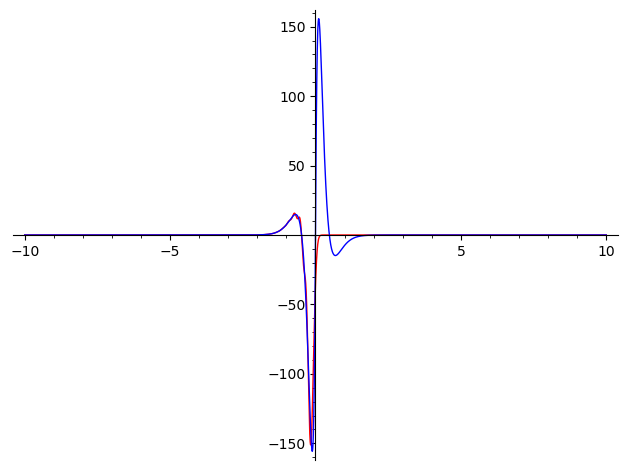

In [29]:
f=lambda_funcs[3]

res, app, err = fit_num(f, basis_pts=[-10 + (2*10*i)/n_base for i in range(100)],train_pts=[-10 + (2*10*i)/n_base for i in range(200)], basis_type='G', sigma=1/12, )

line1 = plot(app, (x, -10, 10),color='red')
line2 = plot(f, (x, -10, 10),color='blue')
line1+line2

We want to approximate in $H^3(\mathbb{R})$ the kernel operator $T : f \mapsto \displaystyle \int_\mathbb{R} K(x,y)f(y)\mathrm{d}y$ using gaussians.  
Assuming that we can bound the kernel away from zero, we only need to find an approximation on a bounded (compact) domain $[-A,A]$, provided that the approximation also decays fast enough at infinity.  
We first discretize the integral operator using a Riemann sum : $ T(f)(x) \approx \displaystyle \sum_{i=1}^n \delta K(x,y_i)f(y_i) $  
Then we approximate each $K(x,y_i)$ separately using gaussians (maybe we should directly approximate the Riemann sum): $K(x,y_i) \approx \displaystyle \sum_{j=1}^n c_{i,j} e^{-\frac{(x-x_j)^2}{2\sigma}} $  
Finally, since $f\mapsto f(x_i)$ is represented in $H^3(\mathbb{R})$ by the inverse Fourier transform of $\displaystyle \frac{e^{2i\pi \xi x_i}}{(1+\xi^2)^3}$, denoted $\eta_{x_i}(x)$, the approximate operator can be written as :  
$T_n : f \mapsto \displaystyle \int_\mathbb{R} K_n(x,y)f(y)\mathrm{d}y$, where $K_n(x,y) = \displaystyle \sum_{i=1}^n \sum_{j=1}^n c_{i,j} e^{ \frac{(x-x_j)^2}{2\sigma}}\eta_{y_i}(y) $.

We now need to numerically compute the $H^3([-A,A])$ norm of the difference with rigorous bounds, and hope that it is small enough for a not too large $n$.

In [ ]:
A=1
n_riem=10
n_basis=200
n_train = 300
basis_pts=grid(A,n_basis)
train_pts=grid(A,n_train)

K=M_0_func

riemann_points,approx_M = riemann_sum(K,-A,A,n_riem)
c = [[0 for j in range(n_basis)] for i in range(n_riem)] # c[i] is the list of the coefficients of the gaussian kernel that approximates K(x,y_i)
for i in range(n_riem):
    coefficients, approx, err = fit_num(lambda x: K(x,riemann_points[i]), basis_pts, train_pts, sigma=1/40, basis_type='G')
    c[i]=coefficients

Mean squared error: 3.127098517987118e-12
Mean squared error: 1.3614421844614648e-10
Mean squared error: 1.484191508440888e-09
Mean squared error: 1.3314149924507124e-09
Mean squared error: 3.599741452698064e-08
Mean squared error: 5.2877099423139894e-08
Mean squared error: 3.5997030596421525e-08
Mean squared error: 1.3314003773210805e-09
Mean squared error: 1.4842129201225397e-09
Mean squared error: 1.3614037152471682e-10


In [ ]:
def compute_approx_kernel(K,A,n_riem,n_basis,n_train,sigma=1/2, basis_type='G'):
    basis_pts=[-A + (2*A*i)/n_base for i in range(n_basis)]
    train_pts=[-A + (2*A*i)/n_train for i in range(n_train)]
    riemann_points,approx_M = riemann_sum(K,-A,A,n_riem)
    c = [[0 for j in range(n_basis)] for i in range(n_riem)]
    for i in range(n_riem):
        coefficients, approx, err = fit_num(lambda x: K(x,riemann_points[i]), basis_pts, train_pts, sigma, basis_type)
        c[i]=coefficients
    def eta(x_i,x):
        return lambda_funcs[0](x-x_i)
    def K_approx(x,y):
        s=RBF(0)
        for i in range(n_riem):
            for j in range(n_basis):
                s+= RBF(c[i][j])*RBF(G(x, basis_pts[j], sigma))*eta(riemann_points[i],y)
        return s
    return K_approx

In [ ]:
K=M_0_func

K_n = compute_approx_kernel(K,1,10,200,300,1/40)

print(riemann_integral(lambda x, y: (K(x, y) - K_n(x, y))**2, -1, 1, -1, 1, 50))


In [ ]:
test_x=[-1+2*i/n for i in range(15)]

test_y=[-1+2*(i+1/2)/n for i in range(15)]

for x in test_x:
    for y in test_y:
        print(x,y,K(x,y)-K_n(x,y))

In [ ]:
K=fast_callable(x^2+y^2,vars=[x,y],domain=RBF)

K_n = compute_approx_kernel(K,1,10,100,200,1/40)

print(riemann_integral(lambda x, y: (K(x, y) - K_n(x, y))**2, -1, 1, -1, 1, 50))